In [90]:
import collections
import os
import json

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd


PATH_RESOURCES = "../segmenter_checkpoint"

sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    font_scale=1.5,
)

def all_cls_attrs(attr: str) -> list[str]:
    return [f"{attr}_{i}" for i in range(4)]

In [26]:
df = []

for layer_count in (2, 4, 6, 8, 10, 12):
    try:
        file_uri = os.path.join(PATH_RESOURCES, f"{layer_count}_layer_model", "all_results.json")
        with open(file_uri, "r") as f:
            df_col = pd.DataFrame.from_dict({layer_count: json.load(f)}, orient="index")
    
    except FileNotFoundError:
        continue
        
    df.append(df_col)

    
df = pd.concat(df).T
df

,2,4,6
epoch,4.000000,4.000000,4.000000
test_loss,0.004714,0.003769,0.003804
test_macro_f1,0.913440,0.928159,0.926896
test_macro_precision,0.957586,0.956748,0.950410
test_macro_recall,0.873184,0.901230,0.904519
test_overall_accuracy,0.998697,0.998939,0.998900
test_per_cls_precision_0,0.999279,0.999427,0.999385
test_per_cls_precision_1,0.981373,0.984958,0.985567
test_per_cls_precision_2,0.953663,0.963052,0.962023
test_per_cls_precision_3,0.896030,0.879556,0.854663


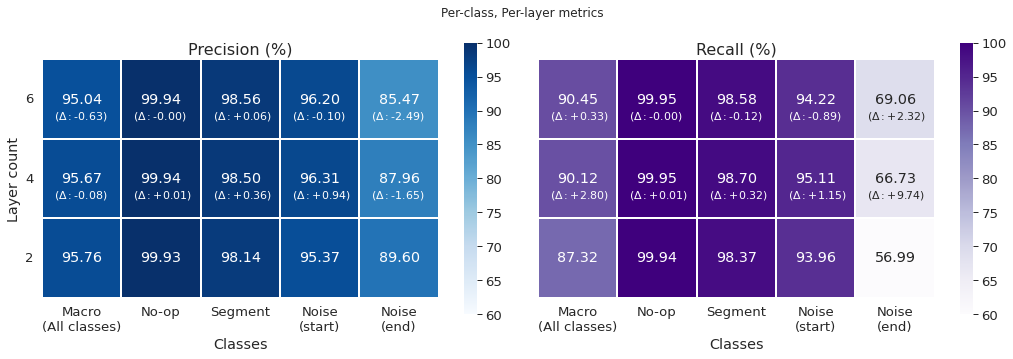

In [316]:
height = 5
width = (16.0 / 9.0) * height

scale = 100.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * width, height), sharex=True, sharey=True)

ax_aspect = "equal"
ax1.set_aspect(ax_aspect)
ax2.set_aspect(ax_aspect)

rotation = 0
xticklabels = ["Macro\n(All classes)", "No-op", "Segment", "Noise\n(start)", "Noise\n(end)"]
yticklabels = df.columns

conf_heatmap = dict(
    square=True,
    linewidths=1.75,
    annot=True,
    fmt=".2f",
    robust=True,
    xticklabels=xticklabels,
    yticklabels=yticklabels,
    vmax=scale * 1.0,
    vmin=scale * 0.6,
    cbar_kws=dict(),
)

fig.suptitle("Per-class, Per-layer metrics", fontsize=12)

subset_1 = scale * df.loc[["test_macro_precision", *all_cls_attrs("test_per_cls_precision")]]
subset_2 = scale * df.loc[["test_macro_recall", *all_cls_attrs("test_per_cls_recall")]]

def apply_delta_annot(ax, subset):
    n, m = subset.shape
    
    cols = np.full_like(subset, fill_value=None, dtype=object)
    
    children = ax.get_children()
    
    for i in range(n):
        for j in range(m):
            cols[i, j] = children[1 + i * m + j].get_color()
    
    for i in range(1, n):
        for j in range(m):
            dlt_val = subset.values[i, j] - subset.values[i - 1, j]
            sign = "+" if dlt_val >= 0 else "-"
            ax.annotate(
                f"\n($\Delta:${sign}{abs(dlt_val):.2f})",
                xy=(j, i),
                xytext=(12, 20),
                color=cols[i, j],
                fontsize=11,
                textcoords='offset points',
            )

hm_1 = sns.heatmap(subset_1.T, ax=ax1, **conf_heatmap, cmap="Blues")
hm_1.set_xlabel("Classes")
hm_1.set_ylabel("Layer count")
hm_1.set_title("Precision (%)", fontsize=16)

hm_2 = sns.heatmap(subset_2.T, ax=ax2, **conf_heatmap, cmap="Purples")
hm_2.set_xlabel("Classes")
hm_2.set_title("Recall (%)", fontsize=16)

ax1.set_xticklabels(labels=xticklabels, rotation=rotation)
ax1.set_yticklabels(labels=yticklabels, rotation=rotation)
ax1.invert_yaxis()

apply_delta_annot(ax1, subset_1.T)
apply_delta_annot(ax2, subset_2.T)

plt.subplots_adjust(wspace=0.0, hspace=0.0)